#### python program to create bounding box folder with labels of format: min_x, max_x, min_y, max_y<br>
python: 3.10.15<br>

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shutil

# Merging stem dataset
orig_test_folder = './TomatoSegmentation/test/labels/'
orig_train_folder = './TomatoSegmentation/train/labels/'
orig_valid_folder = './TomatoSegmentation/valid/labels'

orig_test_df = pd.DataFrame()
orig_train_df = pd.DataFrame()
orig_valid_df = pd.DataFrame()

# Rut dataset
orig_rut_test_folder = './tomatoDataset/test/labels/'
orig_rut_train_folder = './tomatoDataset/train/labels/'
orig_rut_valid_folder = './tomatoDataset/valid/labels/'

orig_rut_test_df = pd.DataFrame()
orig_rut_train_df = pd.DataFrame()
orig_rut_valid_df = pd.DataFrame()

#### <u>Original class mapping:</u>
TomatoRutDataset: <br>
0 - GTomato<br>
1 - HTomato<br>
2 - RTomato<br><br>

TomatoSegmentation dataset:<br>
0 - branch<br>
1 - greeen_tomato -> GTomato<br>
2 - tomato -> RTomato<br><br>

MergedTomatoes dataset:<br>
0 - GTomato -> gets green_tomato<br>
1 - HTomato<br>
2 - RTomato -> gets tomato<br>
3 - Branch -> new<br>


In [2]:
# Merging stem dataset

# function to read original data into bounding box df
def txt_to_box_df(label_folder, df):
    data = []       # store row data here in dict form

    for label_file in os.listdir(label_folder):     # Output: 2024-06-27-105614_jpg.rf.6949ccddc171118deefd29228e391b5c.txt
        # Read file content to df and return filled df
        label_full_path = os.path.join(label_folder, label_file)
        with open(label_full_path, 'r') as file:
            lines = file.readlines()
            # Create the df
            for line in lines:
                elements = line.strip().split()  # Split line into components
                if len(elements) < 5:  # Ensure the line has enough elements
                    continue
                
                class_id = int(elements[0])
                coordinates = list(map(float, elements[1:]))
                
                # Calculate min_x, max_x, min_y, max_y
                points = [(coordinates[i], coordinates[i + 1]) for i in range(0, len(coordinates), 2)]
                xs = [p[0] for p in points]
                ys = [p[1] for p in points]
                min_x, max_x = min(xs), max(xs)
                min_y, max_y = min(ys), max(ys)

                # 
                data.append([label_file, class_id, min_x, max_x, min_y, max_y])
    
    df = pd.DataFrame(data, columns=['file_name', 'class_id', 'min_x', 'max_x', 'min_y', 'max_y'])

    return df


def modify_bounding_boxes(df):
    # Compute x_center, y_center, width, and height from min_x, max_x, min_y, max_y
    df['x_center'] = (df['min_x'] + df['max_x']) / 2
    df['y_center'] = (df['min_y'] + df['max_y']) / 2
    df['width'] = df['max_x'] - df['min_x']
    df['height'] = df['max_y'] - df['min_y']
    return df

In [3]:
# Rut dataset
def txt_to_bounding_box_df(label_folder, df):
    data = []  # Store row data here in dict form

    for label_file in os.listdir(label_folder):  # Output: 2024-06-27-105614_jpg.rf.6949ccddc171118deefd29228e391b5c.txt
        # Read file content to df and return filled df
        label_full_path = os.path.join(label_folder, label_file)
        with open(label_full_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            # Create the df
            for line in lines:
                elements = line.strip().split()  # Split line into components
                if len(elements) < 5:  # Ensure the line has enough elements
                    continue

                # Read the values directly from the file
                class_id = int(elements[0])
                x_center = float(elements[1])
                y_center = float(elements[2])
                width = float(elements[3])
                height = float(elements[4])

                # Append to the list of data
                data.append([label_file, class_id, x_center, y_center, width, height])

    # Convert to a pandas DataFrame
    df = pd.DataFrame(data, columns=['file_name', 'class_id', 'x_center', 'y_center', 'width', 'height'])

    return df

In [4]:
def visualize_image_bounding_boxes(image_path, df):
    # Extract the image name without the extension
    image_name = os.path.basename(image_path).replace('.jpg', '')
    
    # Filter DataFrame for annotations related to the image
    image_annotations = df[df['file_name'] == f"{image_name}.txt"]
    
    if image_annotations.empty:
        print(f"No annotations found for {image_name}")
        return
    
    # Load the image
    image = Image.open(image_path)
    image_width, image_height = image.size
    image = np.array(image)  # Convert to NumPy array for compatibility with Matplotlib
    
    # Set up the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    # Plot each bounding box
    for _, row in image_annotations.iterrows():
        # Scale bounding box dimensions
        x_center = row['x_center'] * image_width
        y_center = row['y_center'] * image_height
        width = row['width'] * image_width
        height = row['height'] * image_height
        
        # Calculate top-left corner coordinates
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        
        # Ensure bounding box is within image bounds
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        width = min(image_width - x_min, width)
        height = min(image_height - y_min, height)
        
        # Draw the bounding box
        rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        
        # Annotate with class ID
        ax.text(x_min, y_min - 10, f"Class {row['class_id']}", color='red', fontsize=12, weight='bold')

    # Display the image with bounding boxes
    plt.axis('off')
    plt.show()

In [5]:
test_box_df = txt_to_box_df(orig_test_folder, orig_test_df)
test_box_df

,file_name,class_id,min_x,max_x,min_y,max_y
0,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,1,0.079365,0.436508,0.503968,0.760417
1,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,1,0.222884,0.527116,0.688492,0.916171
2,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,1,0.414683,0.533069,0.511409,0.711806
3,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,0,0.204072,0.403331,0.430604,0.514502
4,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,0,0.387592,0.442918,0.451292,0.537383
...,...,...,...,...,...,...
91,IMG_0377_jpg.rf.a291545603b0f73c041c43e06b58be...,2,0.221875,0.513125,0.021111,0.438889
92,IMG_0377_jpg.rf.a291545603b0f73c041c43e06b58be...,2,0.475625,0.838750,0.000000,0.443333
93,IMG_0377_jpg.rf.a291545603b0f73c041c43e06b58be...,0,0.335000,0.447500,0.105556,0.226667
94,IMG_0377_jpg.rf.a291545603b0f73c041c43e06b58be...,0,0.433750,0.512500,0.146667,0.414444


In [6]:
test_box_df = modify_bounding_boxes(test_box_df)
test_box_df.to_csv("test_box_df.csv")
test_box_df

,file_name,class_id,min_x,max_x,min_y,max_y,x_center,y_center,width,height
0,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,1,0.079365,0.436508,0.503968,0.760417,0.257937,0.632192,0.357143,0.256448
1,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,1,0.222884,0.527116,0.688492,0.916171,0.375000,0.802331,0.304233,0.227679
2,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,1,0.414683,0.533069,0.511409,0.711806,0.473876,0.611607,0.118386,0.200397
3,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,0,0.204072,0.403331,0.430604,0.514502,0.303701,0.472553,0.199259,0.083898
4,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,0,0.387592,0.442918,0.451292,0.537383,0.415255,0.494338,0.055327,0.086091
...,...,...,...,...,...,...,...,...,...,...
91,IMG_0377_jpg.rf.a291545603b0f73c041c43e06b58be...,2,0.221875,0.513125,0.021111,0.438889,0.367500,0.230000,0.291250,0.417778
92,IMG_0377_jpg.rf.a291545603b0f73c041c43e06b58be...,2,0.475625,0.838750,0.000000,0.443333,0.657187,0.221667,0.363125,0.443333
93,IMG_0377_jpg.rf.a291545603b0f73c041c43e06b58be...,0,0.335000,0.447500,0.105556,0.226667,0.391250,0.166111,0.112500,0.121111
94,IMG_0377_jpg.rf.a291545603b0f73c041c43e06b58be...,0,0.433750,0.512500,0.146667,0.414444,0.473125,0.280556,0.078750,0.267778


##### Test box conversion with image  ./TomatoSegmentation/test/images/1_JPG.rf.3210105f01414ccbe3abaf4588f8b83b.jpg 

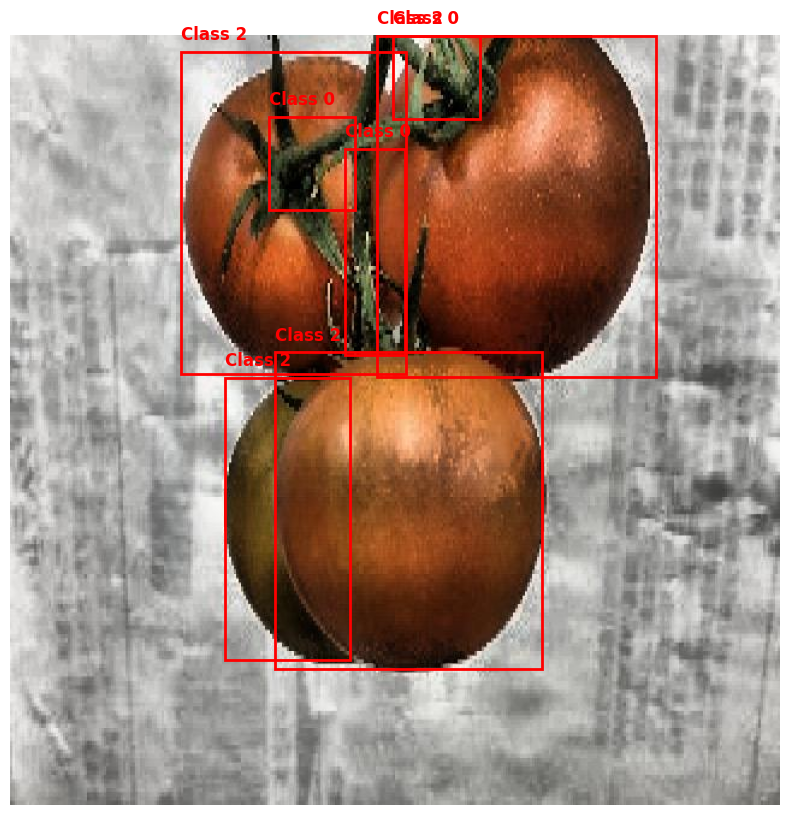

In [7]:
visualize_image_bounding_boxes("./TomatoSegmentation/test/images/IMG_0377_jpg.rf.a291545603b0f73c041c43e06b58be58.jpg", test_box_df)

#### Test RutDataset

In [8]:
orig_rut_test_df = txt_to_bounding_box_df(orig_rut_test_folder, orig_rut_test_df)

##### Test box conversion with image  ./tomatoDataset/test/IMG_1030_jpg.rf.fc94be31a57cd6456c5ed7698f7390f1.jpg

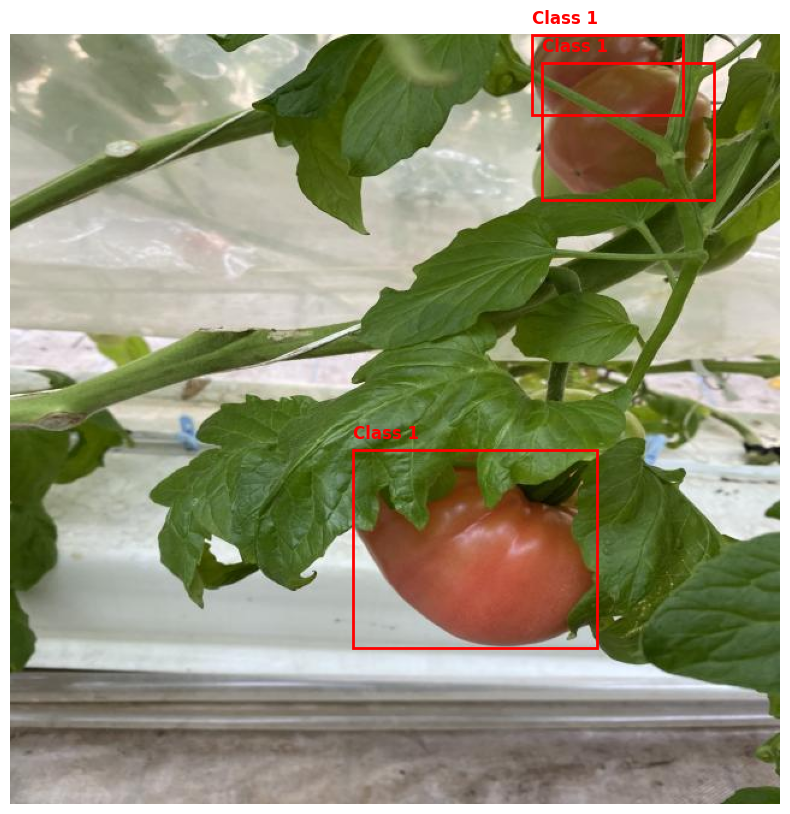

In [9]:
visualize_image_bounding_boxes("./tomatoDataset/test/images/IMG_1030_jpg.rf.fc94be31a57cd6456c5ed7698f7390f1.jpg", orig_rut_test_df)

#### Tests successful<br>
Creation of all dataframes

In [10]:
# Stem dataset
test_box_df = test_box_df
train_box_df = txt_to_box_df(orig_train_folder, orig_train_df)
valid_box_df = txt_to_box_df(orig_valid_folder, orig_valid_df)

test_box_df = test_box_df
train_box_df = modify_bounding_boxes(train_box_df)
valid_box_df = modify_bounding_boxes(valid_box_df)

test_box_df.head()

,file_name,class_id,min_x,max_x,min_y,max_y,x_center,y_center,width,height
0,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,1,0.079365,0.436508,0.503968,0.760417,0.257937,0.632192,0.357143,0.256448
1,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,1,0.222884,0.527116,0.688492,0.916171,0.375000,0.802331,0.304233,0.227679
2,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,1,0.414683,0.533069,0.511409,0.711806,0.473876,0.611607,0.118386,0.200397
3,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,0,0.204072,0.403331,0.430604,0.514502,0.303701,0.472553,0.199259,0.083898
4,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,0,0.387592,0.442918,0.451292,0.537383,0.415255,0.494338,0.055327,0.086091


In [11]:
# Rut dataset no changes needed
orig_rut_test_df.head()

,file_name,class_id,x_center,y_center,width,height
0,IMG_20191215_111613_jpg.rf.7011614fefbeb7f96bb...,0,0.026562,0.708594,0.053125,0.107813
1,IMG_20191215_111613_jpg.rf.7011614fefbeb7f96bb...,0,0.413281,0.422656,0.110156,0.110156
2,IMG_20191215_111613_jpg.rf.7011614fefbeb7f96bb...,0,0.656250,0.475781,0.193750,0.128906
3,IMG_20191215_111613_jpg.rf.7011614fefbeb7f96bb...,1,0.468750,0.313281,0.158594,0.117969
4,IMG_20191215_111613_jpg.rf.7011614fefbeb7f96bb...,1,0.517969,0.411719,0.166406,0.142969


Mapping to new class system

In [12]:
# front: old class, back: new class
stem_mapping = {
    0 : 3,
    1 : 0,
    2: 2
}

# Apply the mapping to update class_id to each stem_df
test_box_df['class_id'] = test_box_df['class_id'].replace(stem_mapping)
train_box_df['class_id'] = train_box_df['class_id'].replace(stem_mapping)
valid_box_df['class_id'] = valid_box_df['class_id'].replace(stem_mapping)


test_box_df.head()
# Mapping successful -

,file_name,class_id,min_x,max_x,min_y,max_y,x_center,y_center,width,height
0,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,0,0.079365,0.436508,0.503968,0.760417,0.257937,0.632192,0.357143,0.256448
1,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,0,0.222884,0.527116,0.688492,0.916171,0.375000,0.802331,0.304233,0.227679
2,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,0,0.414683,0.533069,0.511409,0.711806,0.473876,0.611607,0.118386,0.200397
3,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,3,0.204072,0.403331,0.430604,0.514502,0.303701,0.472553,0.199259,0.083898
4,IMG_1077_jpg.rf.ac16cb7198ae9728023f43126b258f...,3,0.387592,0.442918,0.451292,0.537383,0.415255,0.494338,0.055327,0.086091


In [13]:
def write_bounding_boxes_to_txt(df, output_folder):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Group rows by file_name
    grouped = df.groupby('file_name')
    print(len(grouped))
    
    # Loop through each group and write to the corresponding file
    for file_name, group in grouped:
        # Path to the txt file
        txt_file_path = os.path.join(output_folder, f"{file_name}")
        
        # Open the file in append mode, specifying UTF-8 encoding
        with open(txt_file_path, 'a', encoding='utf-8') as f:
            # Loop through each row in the group
            for _, row in group.iterrows():
                # Prepare the data to write to file (class_id, x_center, y_center, width, height)
                line = f"{row['class_id']} {row['x_center']} {row['y_center']} {row['width']} {row['height']}\n"
                f.write(line)


write_bounding_boxes_to_txt(test_box_df, './stem_recoded/test/labels')
write_bounding_boxes_to_txt(train_box_df, './stem_recoded/train/labels')
write_bounding_boxes_to_txt(valid_box_df, './stem_recoded/valid/labels')

22
429
43


#### Test usage
file: ./stem_recoded/test/images/IMG_1080_jpg.rf.8507b17961a60b17061fc9874d5cf604.jpg

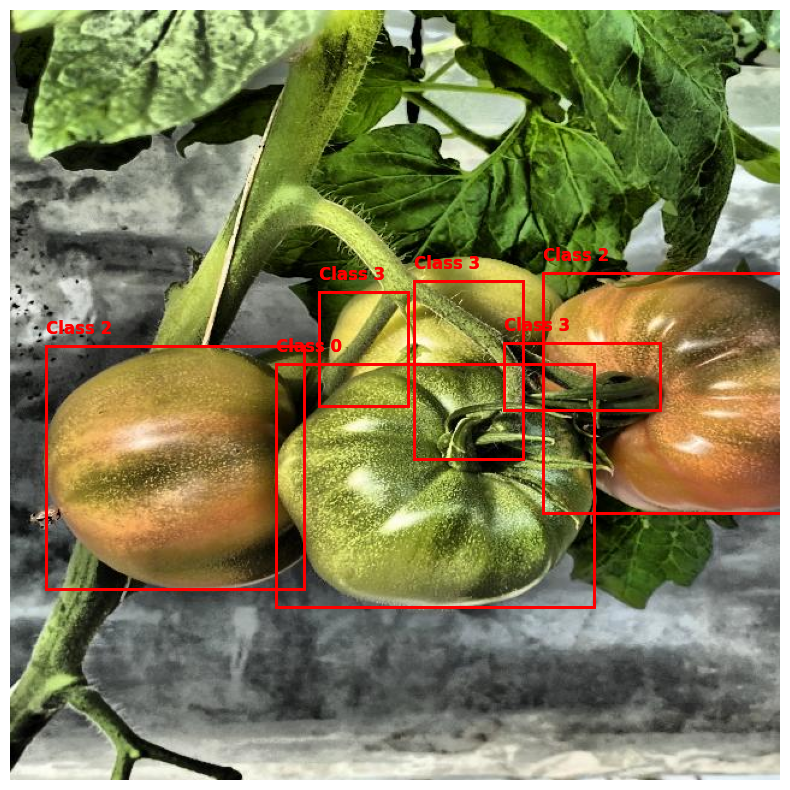

In [14]:
recoded_test_df = pd.DataFrame()
recoded_train_df = pd.DataFrame()
recoded_valid_df = pd.DataFrame()

recoded_test_df = txt_to_bounding_box_df("./stem_recoded/test/labels/", recoded_test_df)
recoded_train_df = txt_to_bounding_box_df("./stem_recoded/train/labels/", recoded_train_df)
recoded_valid_df = txt_to_bounding_box_df("./stem_recoded/valid/labels/", recoded_train_df)


visualize_image_bounding_boxes("./stem_recoded/test/images/IMG_1080_jpg.rf.8507b17961a60b17061fc9874d5cf604.jpg", recoded_test_df)

##### Test successful

##### Check if all images are present

In [15]:
def check_images_in_dataframe(image_folder, df):
    # List all images in the image folder (with .jpg, .jpeg, or .png)
    image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]
    
    # Extract the 'file_name' column from the dataframe, removing the .txt extension
    file_names_in_df = df['file_name'].str.replace('.txt', '.jpg').unique()
    
    # Check which images are not in the dataframe
    missing_images = [img for img in image_files if img not in file_names_in_df]
    
    # Log missing images in the console
    if missing_images:
        print(f"Images not found in dataframe:")
        for img in missing_images:
            print(f" - {img}")
    else:
        print("All images are present in the dataframe.")


In [16]:
# Check images and log missing ones in console
check_images_in_dataframe("./stem_recoded/test/images", recoded_test_df)

All images are present in the dataframe.


In [23]:
# Check images and log missing ones in console
check_images_in_dataframe("./stem_recoded/train/images", recoded_train_df)

All images are present in the dataframe.


In [18]:
# Check images and log missing ones in console
check_images_in_dataframe("./stem_recoded/valid/images", recoded_valid_df)

All images are present in the dataframe.
